In [1]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

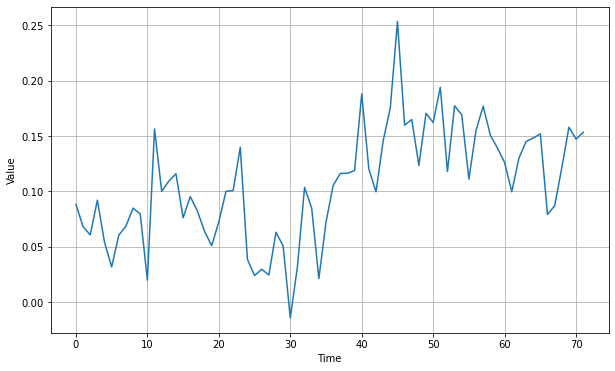

In [3]:
import csv

df = pd.read_csv("./Train Set.csv")
data = df.iloc[10:11,1:]
series = np.array(data).flatten()
series = preprocessing.normalize([series]).flatten()
time = np.arange(72)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [4]:
split_time = 60
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 6
batch_size = 6
shuffle_buffer_size = 24

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [6]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(6).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 6
batch_size = 6
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(36, activation="relu"),
  tf.keras.layers.Dense(12, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mape"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


Epoch 1/100
9/9 [==============================] - 4s 90ms/step - loss: 0.0869 - mape: 368.8087 - lr: 1.0000e-08
Epoch 2/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0630 - mape: 273.1148 - lr: 1.1220e-08
Epoch 3/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0410 - mape: 225.0195 - lr: 1.2589e-08
Epoch 4/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0305 - mape: 233.1974 - lr: 1.4125e-08
Epoch 5/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0271 - mape: 256.7896 - lr: 1.5849e-08
Epoch 6/100
9/9 [==============================] - 0s 4ms/step - loss: 0.0261 - mape: 273.6734 - lr: 1.7783e-08
Epoch 7/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0255 - mape: 275.6841 - lr: 1.9953e-08
Epoch 8/100
9/9 [==============================] - 0s 4ms/step - loss: 0.0245 - mape: 269.2275 - lr: 2.2387e-08
Epoch 9/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0235 - mape: 256.8269 - lr: 2.

Epoch 74/100
9/9 [==============================] - 0s 3ms/step - loss: 7.0875 - mape: 11573.2549 - lr: 4.4668e-05
Epoch 75/100
9/9 [==============================] - 0s 3ms/step - loss: 6.9450 - mape: 10951.3408 - lr: 5.0119e-05
Epoch 76/100
9/9 [==============================] - 0s 3ms/step - loss: 4.1991 - mape: 6968.7949 - lr: 5.6234e-05
Epoch 77/100
9/9 [==============================] - 0s 3ms/step - loss: 5.0283 - mape: 8131.9946 - lr: 6.3096e-05
Epoch 78/100
9/9 [==============================] - 0s 4ms/step - loss: 11.6194 - mape: 16178.6045 - lr: 7.0795e-05
Epoch 79/100
9/9 [==============================] - 0s 3ms/step - loss: 19.7462 - mape: 31035.3887 - lr: 7.9433e-05
Epoch 80/100
9/9 [==============================] - 0s 4ms/step - loss: 9.0903 - mape: 14365.2959 - lr: 8.9125e-05
Epoch 81/100
9/9 [==============================] - 0s 3ms/step - loss: 10.6885 - mape: 19153.9922 - lr: 1.0000e-04
Epoch 82/100
9/9 [==============================] - 0s 3ms/step - loss: 7.6587 

(1e-08, 0.0001, 0.0, 0.02)

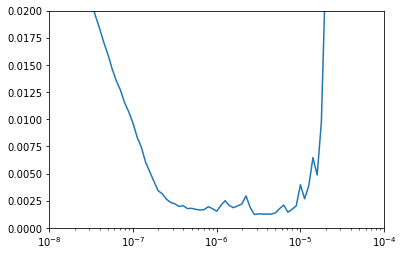

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 0.02])


In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=12, batch_size=6, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(36, activation="relu"),
  tf.keras.layers.Dense(12, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=5*1e-7, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mape"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
8/8 [==============================] - 3s 8ms/step - loss: 0.0472 - mape: 402.1242
Epoch 2/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0379 - mape: 341.0947
Epoch 3/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0111 - mape: 200.1525
Epoch 4/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0079 - mape: 145.2804
Epoch 5/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0080 - mape: 161.4484
Epoch 6/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0057 - mape: 113.1290
Epoch 7/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0066 - mape: 144.8023
Epoch 8/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0039 - mape: 113.3845
Epoch 9/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0043 - mape: 104.2113
Epoch 10/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0043 - mape: 123.4126
Epoch 11/500
8/8 [==============================]

8/8 [==============================] - 0s 5ms/step - loss: 0.0015 - mape: 84.0593
Epoch 88/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0016 - mape: 80.8596
Epoch 89/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0019 - mape: 79.4292
Epoch 90/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0016 - mape: 91.3676
Epoch 91/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0016 - mape: 68.1900
Epoch 92/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0020 - mape: 91.9802
Epoch 93/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0014 - mape: 74.6794
Epoch 94/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0015 - mape: 80.5641
Epoch 95/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0017 - mape: 79.6912
Epoch 96/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0017 - mape: 82.9946
Epoch 97/500
8/8 [==============================] - 0s 6ms/step

8/8 [==============================] - 0s 5ms/step - loss: 0.0013 - mape: 71.9692
Epoch 173/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0013 - mape: 79.1588
Epoch 174/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0013 - mape: 67.7669
Epoch 175/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0014 - mape: 77.0088
Epoch 176/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0014 - mape: 75.3430
Epoch 177/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0013 - mape: 72.0876
Epoch 178/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0013 - mape: 74.2099
Epoch 179/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0014 - mape: 73.4641
Epoch 180/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0015 - mape: 78.3671
Epoch 181/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0013 - mape: 75.2260
Epoch 182/500
8/8 [==============================] - 0

8/8 [==============================] - 0s 5ms/step - loss: 0.0011 - mape: 70.3266
Epoch 258/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0013 - mape: 67.0914
Epoch 259/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0012 - mape: 74.8807
Epoch 260/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0011 - mape: 69.1256
Epoch 261/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0013 - mape: 68.5444
Epoch 262/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0013 - mape: 77.9375
Epoch 263/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0011 - mape: 67.7395
Epoch 264/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0013 - mape: 68.7242
Epoch 265/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0012 - mape: 75.3254
Epoch 266/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0012 - mape: 66.4444
Epoch 267/500
8/8 [==============================] - 0

8/8 [==============================] - 0s 5ms/step - loss: 0.0012 - mape: 68.2564
Epoch 343/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0011 - mape: 69.4322
Epoch 344/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0011 - mape: 65.8479
Epoch 345/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0011 - mape: 67.5723
Epoch 346/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0010 - mape: 66.6929
Epoch 347/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0010 - mape: 63.9484
Epoch 348/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0011 - mape: 68.1138
Epoch 349/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0011 - mape: 64.9367
Epoch 350/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0012 - mape: 73.0361
Epoch 351/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0011 - mape: 69.8453
Epoch 352/500
8/8 [==============================] - 0

8/8 [==============================] - 0s 5ms/step - loss: 0.0011 - mape: 67.9486
Epoch 428/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0011 - mape: 63.2864
Epoch 429/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0011 - mape: 71.9686
Epoch 430/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0010 - mape: 62.9165
Epoch 431/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0011 - mape: 68.6485
Epoch 432/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0010 - mape: 66.4901
Epoch 433/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0011 - mape: 63.7366
Epoch 434/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0011 - mape: 68.6502
Epoch 435/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0010 - mape: 63.2812
Epoch 436/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0011 - mape: 69.2237
Epoch 437/500
8/8 [==============================] - 0

Text(0, 0.5, 'loss')

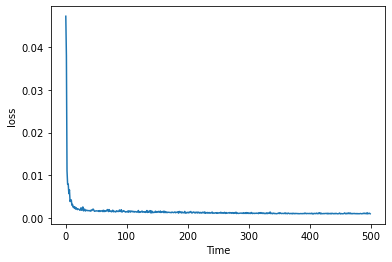

In [10]:
time = np.arange(500)
loss = history.history["loss"]
loss_f = np.array(loss)
np.shape(loss_f)

plt.plot(time, loss_f)
plt.xlabel('Time')
plt.ylabel('loss')

In [11]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

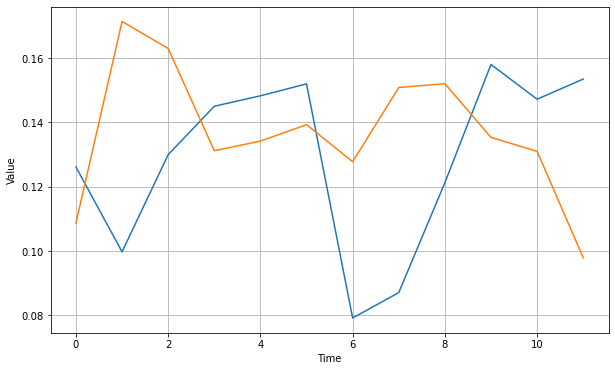

In [12]:
plt.figure(figsize=(10, 6))
time = np.arange(12)
plot_series(time, x_valid)
plot_series(time, rnn_forecast)

In [13]:
tf.keras.metrics.mean_absolute_percentage_error(x_valid, rnn_forecast).numpy()

29.98964

<Figure size 432x288 with 0 Axes>

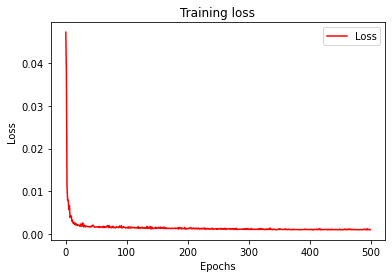

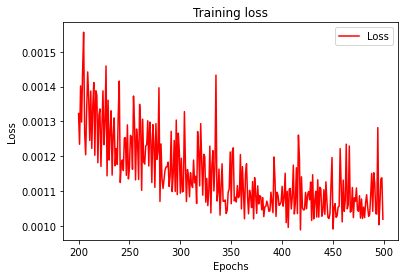

<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [15]:
print(rnn_forecast)

[0.10868774 0.17135975 0.16294387 0.1311808  0.13418019 0.13927959
 0.12775402 0.15082625 0.15202607 0.13532224 0.13098225 0.09791597]
